# Band structure calculation of a photonic crystal slab

In this notebook, we simulate a photonic crystal slab consisting of a square lattice of air holes in a dielectric slab. Our goal is to compute the band structure of this photonic crystal slab, as found in:

> Shanhui Fan and J. D. Joannopoulos, "Analysis of guided resonances in photonic crystal slabs," Phys. Rev. B 65, 235112 (2002).

To this end, we excite the structure with several `PointDipole` sources, and we measure the response with several `FieldTimeMonitor` monitors. We excite modes with a fixed Bloch wavevector by using Bloch boundary conditions. We then use the `ResonanceFinder` to find the resonant frequencies. By sweeping the Bloch wavevector, we obtain the full band structure of the photonic crystal slab.

See also the api reference for `ResonanceFinder` [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# standard python imports
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import xarray as xr
from tidy3d import web
from tidy3d.plugins.resonance import ResonanceFinder

We will randomly position our sources and monitors. Here, we seed the random number generator to guarantee reproducible results.

In [2]:
rng = np.random.default_rng(12345)

Now we define the parameters for the simulation, structure, sources, and monitors.

We take the dipole polarization to be `Hz` and the symmetry to be `(0,0,1)` in order to excite only modes which are even with respect to the xy mirror plane.

In [3]:
# Simulation parameters
runtime_fwidth = 200.0  # in units of 1/frequency bandwidth of the source
t_start_fwidth = (
    5.0  # time to start monitoring after source has decayed, units of 1/frequency bandwidth
)
dPML = 1.0  # space between PhC slabs and PML, in unit of longest wavelength of interest

# Structure parameters (um)
a_lattice = 1  # lattice constant "a"
r_hole = 0.2 * a_lattice  # radius of the air holes
t_slab = 0.5 * a_lattice  # slab thickness
ep_slab = 12  # dielectric constant of the slab
ep_hole = 1  # dielectric constant of the holes

# Frequency range of interest (Hz)
freq_range_unitless = np.array((0.1, 0.43))  # in units of c/a
freq_scale = td.constants.C_0 / a_lattice  # frequency scale determined by the lattice constant
freq_range = freq_range_unitless * freq_scale
lambda_range = (td.constants.C_0 / freq_range[1], td.constants.C_0 / freq_range[0])

# Gaussian pulse parameters
freq0 = np.sum(freq_range) / 2  # central frequency
freqw = 0.3 * (freq_range[1] - freq_range[0])  # pulse width

# Runtime
run_time = runtime_fwidth / freqw
print(f"Total runtime = {(run_time * 1e12):.2f} ps")
t_start = t_start_fwidth / freqw

# Simulation size
spacing = dPML * lambda_range[-1]  # space between PhC slabs and PML
sim_size = Lx, Ly, Lz = (a_lattice, a_lattice, 2 * spacing + t_slab)

# Number of k values to sample, per edge of the irreducible Brillouin zone
Nk = 5

# Number of dipoles and monitors
num_dipoles = 7
num_monitors = 2

# Dipole polarization and symmetry
polarization = "Hz"
symmetry = (0, 0, 1)

Total runtime = 6.74 ps


We define the materials and structures in terms of the above parameters. We take the photonic crystal slab to be lying in the xy plane. Because the photonic crystal slab is periodic in the x and y directions, we only need to simulate a single unit cell, containing the dielectric slab and a single air hole.

In [4]:
def square_l_cavity():
    x0 = 0
    y0 = 0
    z0 = 0
    R = 0.25          # main cylinder radius (µm)
    side_R = 0.2      # corner cylinders
    spacing = 0.6     # lattice constant (µm)
    n_x = 7
    n_y = 7
    l_number = 2      # number of holes removed to form "L"
    height = 0.5      # pillar height (µm)
    medium = td.Medium(permittivity=1.003**2)
    reference_plane = "bottom"
    sidewall_angle = 0
    axis = 2

    cylinders = []
    for i in range(-n_x // 2, n_x // 2 + 1):
        for j in range(-n_y // 2, n_y // 2 + 1):
            # remove pillars to form the L cavity
            if not ((i >= 0 and j == 0 and i <= l_number) or (j >= 0 and i == 0 and j <= l_number)):
                var_radius = side_R if ((i == l_number + 1 and j == 0) or (i == 0 and j == l_number + 1)) else R
                cylinders.append(
                    td.Cylinder(
                        axis=axis,
                        sidewall_angle=sidewall_angle,
                        reference_plane=reference_plane,
                        radius=var_radius,
                        center=(x0 + i * spacing, y0 + j * spacing, z0),
                        length=height,
                    )
                )

    return td.Structure(geometry=td.GeometryGroup(geometries=cylinders), medium=medium)

# Build L-cavity
l_cavity = square_l_cavity()

# ---------------------------------------------------------
# 2. Grid Specification (higher resolution)
# ---------------------------------------------------------
# increase the number of steps per wavelength to better resolve 0.5-µm height
grid_spec = td.GridSpec.auto(min_steps_per_wvl=60)

# ---------------------------------------------------------
# 3. Mesh Override (refine mesh near thin slab)
# ---------------------------------------------------------
mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, 1.0)),  # 1-µm-thick z-region
    dl=(0.04, 0.04, 0.04),  # fine local grid (µm)
)

# ---------------------------------------------------------
# 4. Combine all structures
# ---------------------------------------------------------
structures = [l_cavity, mesh_override]


We will excite the photonic crystal slab with several `PointDipole` sources. Each dipole will have a random position and phase.

In [5]:
dipole_positions = rng.uniform([-Lx / 2, -Ly / 2, 0], [Lx / 2, Ly / 2, 0], [num_dipoles, 3])

dipole_phases = rng.uniform(0, 2 * np.pi, num_dipoles)

pulses = []
dipoles = []
for i in range(num_dipoles):
    pulse = td.GaussianPulse(freq0=freq0, fwidth=freqw, phase=dipole_phases[i])
    pulses.append(pulse)
    dipoles.append(
        td.PointDipole(
            source_time=pulse,
            center=tuple(dipole_positions[i]),
            polarization=polarization,
            name="dipole_" + str(i),
        )
    )

We create `FieldTimeMonitors` to record the field as a function of time at several random locations within the photonic crystal slab. Crucially, we start the monitors after the source pulse has decayed.

In [6]:
monitor_positions = rng.uniform([-Lx / 2, -Ly / 2, 0], [Lx / 2, Ly / 2, 0], [num_monitors, 3])

monitors_time = []
for i in range(num_monitors):
    monitors_time.append(
        td.FieldTimeMonitor(
            fields=["Hz"],
            center=tuple(monitor_positions[i]),
            size=(0, 0, 0),
            start=t_start,
            name="monitor_time_" + str(i),
        )
    )

We will perform `3*Nk` different simulations, each with different Bloch boundary conditions, as we sweep the Bloch wavevector over the boundary of the irreducible Brillouin zone. We sweep over three lines, namely $\Gamma X$, $XM$, and $M\Gamma$. We use a PML in the z direction.

Here, we simply define all of the boundary conditions we will use and put them into a single array.

In [7]:
# --- SQUARE LATTICE BOUNDARY SPECS (Γ–X–M–Γ path) ---

a = a_lattice  # lattice constant (µm)

# Define reciprocal lattice vectors for a square lattice
b1 = (2 * np.pi / a) * np.array([1.0, 0.0])
b2 = (2 * np.pi / a) * np.array([0.0, 1.0])

def frac_to_cart(frac):
    """Convert fractional (u,v) coordinates to Cartesian (kx, ky)."""
    u, v = frac
    return u * b1 + v * b2

# --- Define high-symmetry points in fractional coordinates ---
Gamma_frac = np.array([0.0, 0.0])   # Center
X_frac     = np.array([0.5, 0.0])   # Edge center
M_frac     = np.array([0.5, 0.5])   # Corner

def interpolate_k(frac_start, frac_end, N):
    """Generate list of k-vectors from start→end (fractional coords)."""
    ks = []
    for i in range(N):
        frac = (1 - i / N) * frac_start + (i / N) * frac_end
        ks.append(frac_to_cart(frac))
    return ks

# --- Build path segments for Γ–X–M–Γ ---
k_gammax  = interpolate_k(Gamma_frac, X_frac, Nk)
k_xm      = interpolate_k(X_frac, M_frac, Nk)
k_mgamma  = interpolate_k(M_frac, Gamma_frac, Nk)

# --- Convert to Bloch boundary specs (keep same variable names) ---
bspecs_gammax = []
bspecs_xm = []
bspecs_mgamma = []

for k in k_gammax:
    kx, ky = k / (2 * np.pi / a)
    bspecs_gammax.append(
        td.BoundarySpec(
            x=td.Boundary.bloch(kx),
            y=td.Boundary.bloch(ky),
            z=td.Boundary.pml(),
        )
    )

for k in k_xm:
    kx, ky = k / (2 * np.pi / a)
    bspecs_xm.append(
        td.BoundarySpec(
            x=td.Boundary.bloch(kx),
            y=td.Boundary.bloch(ky),
            z=td.Boundary.pml(),
        )
    )

for k in k_mgamma:
    kx, ky = k / (2 * np.pi / a)
    bspecs_mgamma.append(
        td.BoundarySpec(
            x=td.Boundary.bloch(kx),
            y=td.Boundary.bloch(ky),
            z=td.Boundary.pml(),
        )
    )

# --- Concatenate full path ---
bspecs = bspecs_gammax + bspecs_xm + bspecs_mgamma

print(f"Generated {len(bspecs)} square (Γ–X–M–Γ) Bloch boundary specs.")


Generated 15 square (Γ–X–M–Γ) Bloch boundary specs.


Now we define the simulations we want to run. 

In [8]:
# define grid spec with mesh override integrated
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=40,
    override_structures=[
        td.MeshOverrideStructure(
            geometry=td.Box(center=(0, 0, 0), size=(td.inf, td.inf, 1.0)),  # fine region in z
            dl=(0.04, 0.04, 0.04),
        )
    ],
)

# build simulations
sims = {}
for i in range(3 * Nk):
    sims[f"sim_{i}"] = td.Simulation(
        center=(0, 0, 0),
        size=sim_size,
        grid_spec=grid_spec,             # <-- includes mesh override now
        structures=[l_cavity],           # only real geometry structures here
        sources=dipoles,
        monitors=monitors_time,
        run_time=run_time,
        shutoff=0,
        boundary_spec=bspecs[i],
        normalize_index=None,
        symmetry=symmetry,
    )


Let's check that the structure and source look correct. The source spectrum must fill the entire frequency range of interest.

In [ ]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sims["sim_0"].plot(z=0.0, ax=ax[0])
sims["sim_0"].plot(x=0, freq=freq0, ax=ax[1])
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
plot_time = 5 / freqw
ax1 = (
    sims["sim_0"]
    .sources[0]
    .source_time.plot(times=np.linspace(0, plot_time, 1001), val="abs", ax=ax1)
)
ax1.set_xlim(0, plot_time)
ax2 = (
    sims["sim_0"]
    .sources[0]
    .source_time.plot_spectrum(
        times=np.linspace(0, sims["sim_0"].run_time, 10001), val="abs", ax=ax2
    )
)
ax2.hlines(1.5e-15, freq_range[0], freq_range[1], linewidth=10, color="g", alpha=0.4)
ax2.legend(("source spectrum", "measurement"))
plt.show()

Now we run the simulations as a `Batch`.

We set `verbose=True` to keep track of the status of the jobs in the `Batch`.

In [ ]:
# initialize a batch and run them all
batch = td.web.Batch(simulations=sims, verbose=True)

# run the batch and store all of the data in the `data/` dir.
batch_data = batch.run(path_dir="data")

Now that the simulations are complete, we can analyze the data. Let's first look at one of the FieldTimeMonitors to make sure the source has decayed.

In [ ]:
plt.plot(
    batch_data["sim_1"].monitor_data["monitor_time_0"].Hz.t,
    np.real(batch_data["sim_1"].monitor_data["monitor_time_0"].Hz.squeeze()),
)
plt.title("FieldTimeMonitor data")
plt.xlabel("t")
plt.ylabel("Hz")
plt.show()

We see that the source has mostly decayed by the time we switch on the monitors, and the remaining data shows decay and oscillation due to the resonances inside the system.

Looking at the Fourier transform of this data, we can see resonances at the band frequencies.

In [ ]:
field = batch_data["sim_1"].monitor_data["monitor_time_0"].Hz.squeeze().real

fmesh = np.fft.fftfreq(field.size, np.mean(np.diff(field.t)))
spectrum = np.fft.fft(field)

mask = (fmesh > freq_range[0]) & (fmesh < freq_range[1])

plt.plot(
    fmesh[mask],
    np.abs(spectrum)[mask],
)
plt.title("Spectrum at single wavevector")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

We use the ResonanceFinder plugin to find the band frequencies.

We first construct a `ResonanceFinder` object storing our parameters, and then call `run()` on our list of `FieldTimeData` objects. This will add up the signals from all of the monitors before searching for resonances. The `ResonanceFinder` class has additional methods in case the signal takes another form; see the api reference [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html).

The `run()` method returns an `xr.Dataset` containing the decay rate, Q factor, amplitude, phase, and estimation error for each resonance as a function of frequency.  

In [ ]:
resonance_finder = ResonanceFinder(freq_window=tuple(freq_range))
resonance_data = resonance_finder.run(signals=batch_data["sim_1"].data)
resonance_data.to_dataframe()

We see the four resonances from the previous figure. All four have reasonable Q factors, amplitudes, and errors, so they are likely to represent physical resonances. Note that in order to accurately obtain the Q factor for high-Q modes, it may be necessary to run the simulation for a longer time.

Now we are ready to compute the band structure. We run the resonance finder at every Bloch wavevector.

In [37]:
resonance_finder = ResonanceFinder(freq_window=tuple(freq_range))
resonance_datas = []
for i in range(3 * Nk):
    sim_data = batch_data[f"sim_{i}"]
    resonance_datas.append(resonance_finder.run(signals=sim_data.data))

We define a function to filter resonances based on their Q, amplitude, and error.

In [38]:
def filter_resonances(resonance_data, minQ, minamp, maxerr):
    resonance_data = resonance_data.where(abs(resonance_data.Q) > minQ, drop=True)
    resonance_data = resonance_data.where(resonance_data.amplitude > minamp, drop=True)
    resonance_data = resonance_data.where(resonance_data.error < maxerr, drop=True)
    return resonance_data

We plot the band structure with the light line overlaid.

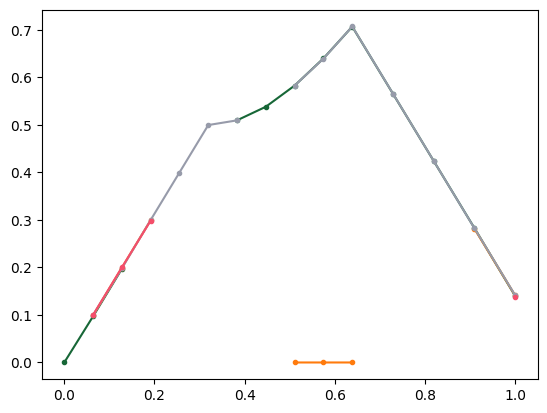

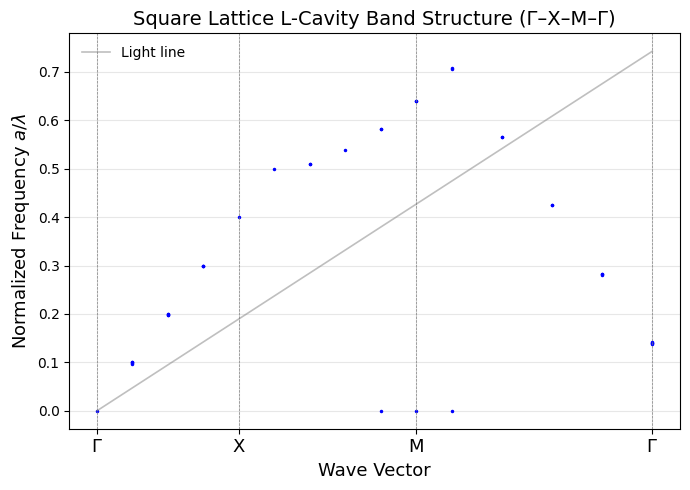

In [41]:
def connect_bands(freqs_norm):
    """
    freqs_norm: list of 1D arrays, one per k-point, each containing the eigen-frequencies at that k.
    Returns: bands [n_k, n_bands] with NaNs for missing/failed modes, ordered for continuity.
    """
    n_k = len(freqs_norm)
    n_bands = max(len(f) for f in freqs_norm)
    bands = np.full((n_k, n_bands), np.nan)

    # k = 0: sort ascending to start
    f0 = np.sort(np.asarray(freqs_norm[0]))
    bands[0, :len(f0)] = f0

    # Try to import Hungarian; fall back to greedy if unavailable
    try:
        from scipy.optimize import linear_sum_assignment
        use_hungarian = True
    except Exception:
        use_hungarian = False

    for k in range(1, n_k):
        prev = bands[k-1]
        curr = np.sort(np.asarray(freqs_norm[k]))
        # indices of valid entries
        prev_idx = np.where(~np.isnan(prev))[0]
        nb_prev = len(prev_idx)
        nb_curr = len(curr)

        if nb_prev == 0 or nb_curr == 0:
            # nothing to match
            bands[k, :nb_curr] = curr[:min(n_bands, nb_curr)]
            continue

        # Build cost matrix |prev - curr|
        C = np.full((nb_curr, nb_prev), np.inf)
        for i in range(nb_curr):
            for j, pj in enumerate(prev_idx):
                C[i, j] = abs(curr[i] - prev[pj])

        if use_hungarian:
            # Hungarian gives minimal total mismatch
            r, c = linear_sum_assignment(C)
            # place as many as we can up to n_bands
            for i, j in zip(r, c):
                bands[k, prev_idx[j]] = curr[i]
            # any leftover (new/appearing modes) go into empty slots
            placed = set(r.tolist())
            empty = np.where(np.isnan(bands[k]))[0]
            for i in range(nb_curr):
                if i not in placed and len(empty):
                    bands[k, empty[0]] = curr[i]
                    empty = empty[1:]
        else:
            # Greedy: repeatedly match closest remaining pair
            prev_avail = prev_idx.tolist()
            curr_avail = list(range(nb_curr))
            while prev_avail and curr_avail:
                best = None
                for i in curr_avail:
                    for j in prev_avail:
                        val = abs(curr[i] - prev[j])
                        if best is None or val < best[0]:
                            best = (val, i, j)
                _, i, j = best
                bands[k, j] = curr[i]
                curr_avail.remove(i)
                prev_avail.remove(j)
            # put any leftovers into empty columns
            empty = np.where(np.isnan(bands[k]))[0]
            for i in curr_avail[:len(empty)]:
                bands[k, empty[i]] = curr[i]

    return bands

bands = connect_bands(freqs_norm)      # [n_k, n_bands]

# plot lines for each band
n_k, n_bands = bands.shape
for b in range(n_bands):
    y = bands[:, b]
    if np.all(np.isnan(y)): 
        continue
    # draw lines through existing points; NaNs will break the line where data is missing
    plt.plot(k_dist, y, marker='o', ms=3)

# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------
plt.figure(figsize=(7, 5))

# Plot each resonance dataset's frequencies
for i, f in enumerate(freqs_norm):
    plt.plot(np.full_like(f, k_dist[i]), f, "b.", ms=3)

# ---------------------------------------------------------
# Add light line overlay (ω = ck)
# ---------------------------------------------------------
lightx = np.linspace(0, 1, 200)
max_freq = max([np.max(f) for f in freqs_norm if len(f) > 0]) * 1.05
lighty = lightx * max_freq  # linear dispersion (air)
plt.plot(lightx, lighty, color="gray", alpha=0.5, lw=1.2, label="Light line")

# Symmetry lines and labels
for t in tick_positions:
    plt.axvline(t, color="gray", lw=0.5, ls="--")

plt.xticks(tick_positions, tick_labels, fontsize=13)
plt.ylabel(r"Normalized Frequency $a / \lambda$", fontsize=13)
plt.xlabel("Wave Vector", fontsize=13)
plt.title("Square Lattice L-Cavity Band Structure (Γ–X–M–Γ)", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


The bandstructure we obtained matches the expected result from the paper. If we were seeing too many resonances, we could change the parameters to our filter_resonances function to eliminate the spurious ones. If we were seeing too few resonances even before filtering, we might have to change the parameters of the ResonanceFinder, for example decreasing `rcond` or increasing `init_num_freqs`. If the ResonanceFinder takes too long, we can decrease `init_num_freqs`. There can also be resonances on the light line associated with Wood's anomaly; we filter those out here based on their small amplitude.